<a href="https://colab.research.google.com/github/andreidimaano/DefinitelyNotBrunoMars/blob/main/visualizations_(just_plots).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/DLproject

Mounted at /content/gdrive
/content/gdrive/My Drive/DLproject


In [ ]:
import soundfile as sf
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import librosa
import pandas as pd
import IPython.display as ipd
import os
import random

#Download song from shared folder to local folder

In [ ]:
def convert_download(path):
  file_path, _ = os.path.splitext(path)
  name = os.path.basename(file_path)
  sample, sr = librosa.load(path)
  sf.write(str(name)+".wav", sample, sr)

# convert_download("/content/gdrive/My Drive/DLproject/IU - MUSIC/Singles Feat/Singles/[2020] Eight [Prod.&Feat. SUGA of BTS].flac")
# convert_download("/content/gdrive/My Drive/DLproject/IU - MUSIC/Singles Feat/Singles/[2018] BBIBBI (삐삐).flac")
convert_download("/content/gdrive/My Drive/DLproject/IU - MUSIC/[2017] Palette/8. Through the Night (밤편지).flac")

In [ ]:
! ls '/content/gdrive/My Drive/DLproject/'

'[2011] Alicia [OST Alicia].wav'
'[2011] Someday [OST Dream High].wav'
'[2018] BBIBBI (삐삐).wav'
'[2020] Eight [Prod.&Feat. SUGA of BTS].wav'
'8. Through the Night (밤편지).wav'
 bruno_spec.h5
 Convert.ipynb
 DanceTarget.mp4
 EverybodyDanceNow_reproduce_pytorch
 find_top_freq.ipynb
'IU - MUSIC'
'IU(아이유) - BBI BBI(삐삐) Dancer Cover  Cover by SuHyun (Mirror Mode) @MAMA.mp4'
'openpose _on_source.avi'
 run_Dance.ipynb
 top_freq.csv
 visualizations


In [ ]:
# path to songs in shared folder
song1_path = "/content/gdrive/My Drive/DLproject/IU - MUSIC/Singles Feat/Singles/[2020] Eight [Prod.&Feat. SUGA of BTS].flac"
song2_path = "/content/gdrive/My Drive/DLproject/IU - MUSIC/Singles Feat/Singles/[2018] BBIBBI (삐삐).flac"
song3_path = "/content/gdrive/My Drive/DLproject/IU - MUSIC/[2021] Lilac/1. LILAC.flac"
demo_song = "/content/gdrive/My Drive/DLproject/IU - MUSIC/[2017] Palette/8. Through the Night (밤편지).flac"

In [ ]:
sample, sr = librosa.load(demo_song)
# ipd.Audio(filename=demo_song)
ipd.Audio(data=sample, rate=sr)

#Signal Augment Function Definitions

In [ ]:
# time stretch issue:
# audio_stretched speeds up / slows down audio but resampled negates the effect
# the result is a pitch shifted audio at original speeds
# possible fix? : https://librosa.org/doc/main/generated/librosa.util.fix_length.html
def time_stretch(data, factor):
  audio_stretched = librosa.effects.time_stretch(data, rate = factor)
  # audio_stretched_resampled = librosa.resample(audio_stretched,  orig_sr = len(audio_stretched), target_sr = len(data))
  return audio_stretched #audio_stretched_resampled

def pitch_shift(data, sr, steps):
  return librosa.effects.pitch_shift(data, sr=sr, n_steps=steps)

def white_noise(data, intensity): # needs testing
  w_noise = np.random.normal(0, data.std(), data.size)
  # may need to replace self.sr with data.size
  new_data = data + (intensity * w_noise)
  return new_data
    
def harm_distort(data): # needs testing
   # https://arxiv.org/pdf/1912.07756.pdf
   new_data = np.sin(np.sin(np.sin(np.sin(np.sin(2*np.pi*data)))))
   return new_data

#Audio Examples of Augmentaitons

In [ ]:
sample, sr = librosa.load("/content/gdrive/My Drive/DLproject/8. Through the Night (밤편지).wav")
# print(sample.size)

# time stretch
# issue : size increases / decreases and resample counters any speed change
# suggestion : https://librosa.org/doc/main/generated/librosa.util.fix_length.html

# 2x speed
ts_fast = time_stretch(sample, 2)
# 1/2x speed
ts_slow = time_stretch(sample, 0.5)

# pitch shift
# 1 octave up
ps_up = pitch_shift(sample, sr, 12)
# 1 octave down
ps_down = pitch_shift(sample, sr, -12)

# white noise
# low 
wnl = white_noise(sample, .2)
# high
wnh = white_noise(sample, 2)

# harmonic distortion
hd = harm_distort(sample)

In [ ]:
# original audio
ipd.Audio(data=sample, rate=sr)

In [ ]:
# time stretch (speed up)
ipd.Audio(data=ts_fast, rate=sr)

In [ ]:
# time stretch (slow dow)
ipd.Audio(data=ts_slow, rate=sr)

In [ ]:
# pitch shift (1 octave up)
ipd.Audio(data=ps_up, rate=sr)

In [ ]:
# pitch shift (1 octave down)
ipd.Audio(data=ps_down, rate=sr)

In [ ]:
# white noise (low)
ipd.Audio(data=wnl, rate=sr)

In [ ]:
# white noise (high)
ipd.Audio(data=wnh, rate=sr)

In [ ]:
# harmonic distortion (lol)
ipd.Audio(data=hd, rate=sr)

#Define Plot functions (Signal and Spectrogram)

In [ ]:
def sgram(audio, sr, title):
  # mel spectrogram
  # S = librosa.feature.melspectrogram(y=audio, sr=sr) # n_mels = 80, 128, etc
  # S_DB = librosa.power_to_db(S, ref=np.max)
  # img1 = librosa.display.specshow(S_DB, x_axis='time', y_axis='mel', sr=sr, ax=axs[1]) #  fmax=8000

  # fig, ax = plt.subplots(figsize=(14, 3))
  # ax.set_title(title)
  # img1 = librosa.display.specshow(S_DB, x_axis='time', y_axis='mel', sr=sr, ax=ax) #  fmax=8000
  # fig.colorbar(img1, ax=ax, format='%+2.0f dB')
  # plt.show()

  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

  fig, ax = plt.subplots(figsize=(16, 3))
  ax.set_title(title)
  img1 = librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
  fig.colorbar(img1, ax=ax, format='%+2.0f dB')
  plt.show()
  return

def print_graph(data, sr, title):
  plt.figure(figsize=(14,3))
  plt.title(title)
  x = np.arange(data.size)/sr
  plt.plot(x, data, lw = 0.5)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude (unitless)")
  plt.show()
  return

#Original Audio Signal and Spectrogram

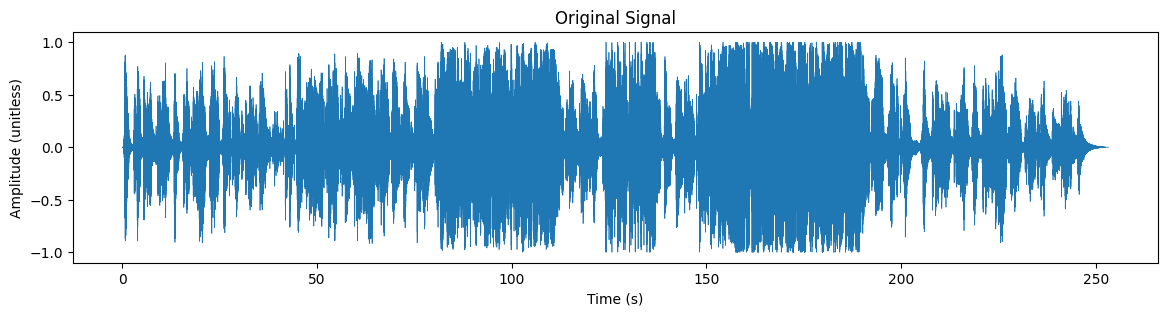

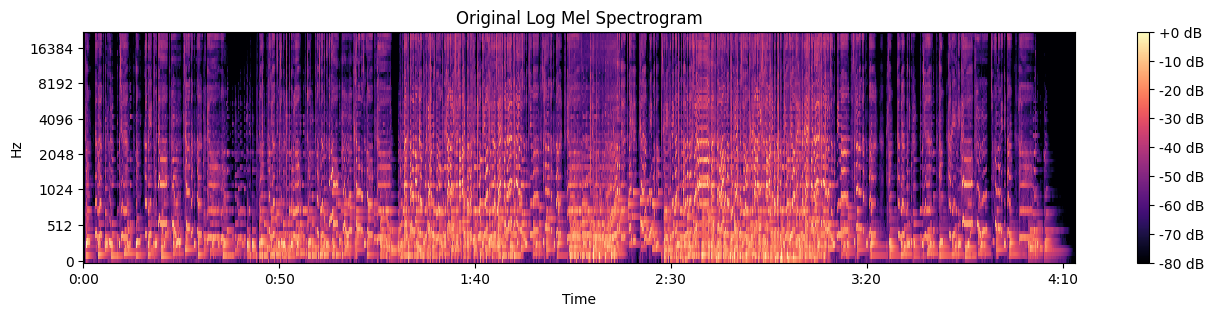

In [ ]:
ori_path = "/content/gdrive/My Drive/DLproject/8. Through the Night (밤편지).wav"
sample, sr = librosa.load(ori_path)
print_graph(sample, sr, "Original Signal")
sgram(sample, sr, "Original Log Mel Spectrogram")

#Time Stretch Audio Signal and Spectrogram (Speed Up and Slow Down)

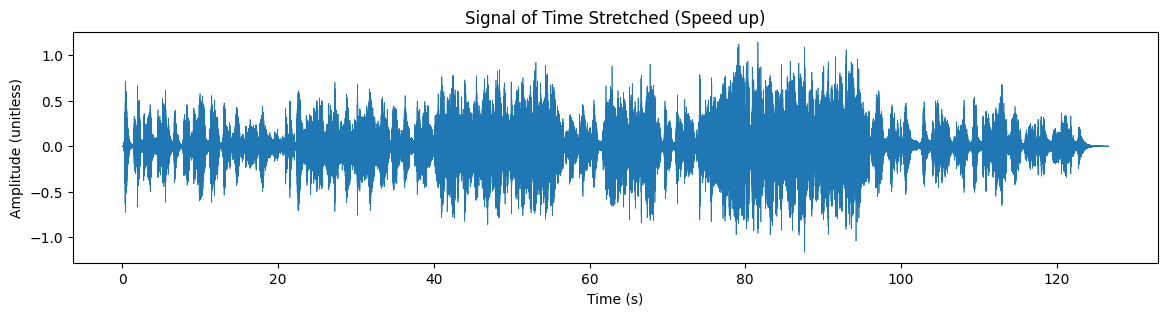

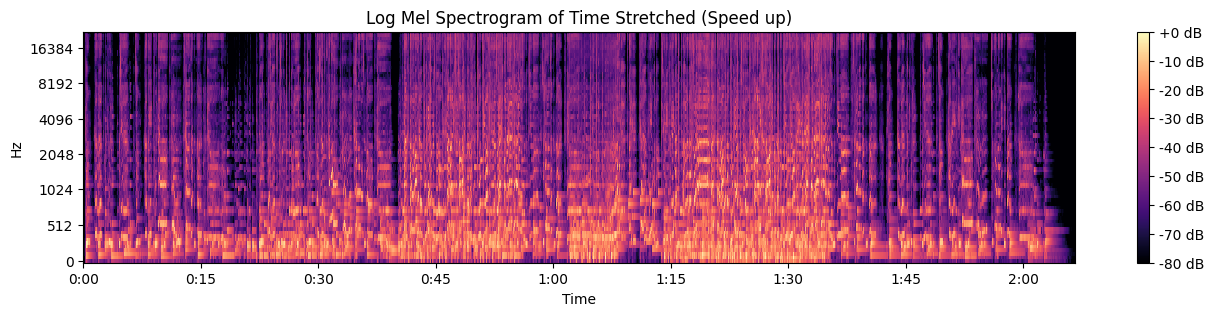

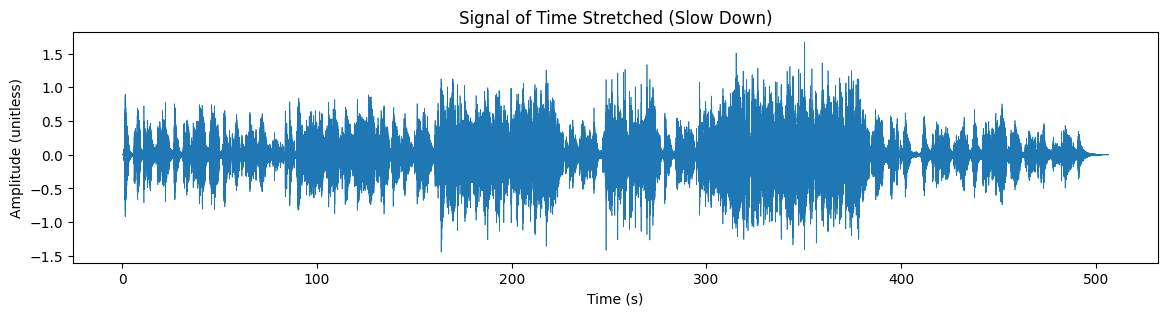

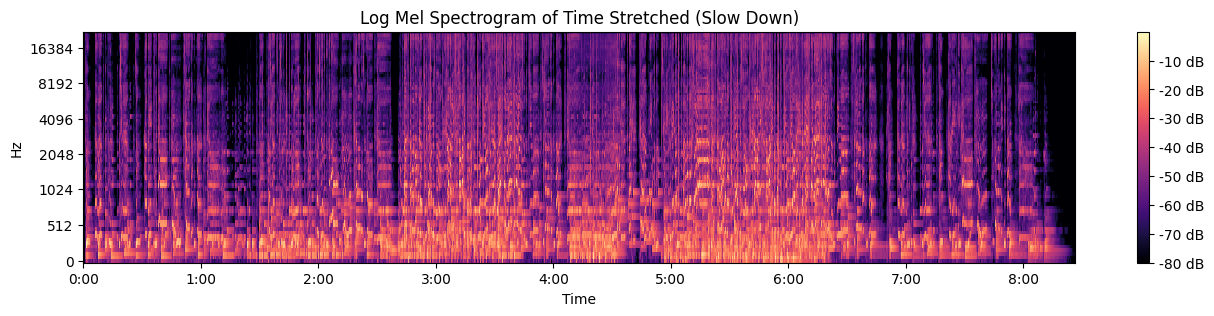

In [ ]:
# 2x speed up
sample, sr = librosa.load(ori_path)
speed_up = time_stretch(sample, 2)
print_graph(speed_up, sr, "Signal of Time Stretched (Speed up)")
sgram(speed_up, sr, "Log Mel Spectrogram of Time Stretched (Speed up)")

# 0.5x slow down
slow_down = time_stretch(sample, 0.5)
print_graph(slow_down, sr, "Signal of Time Stretched (Slow Down)")
sgram(slow_down, sr, "Log Mel Spectrogram of Time Stretched (Slow Down)")

# Pitch Shift Audio Signal and Spectrogram (Octave Up and Octave Down)

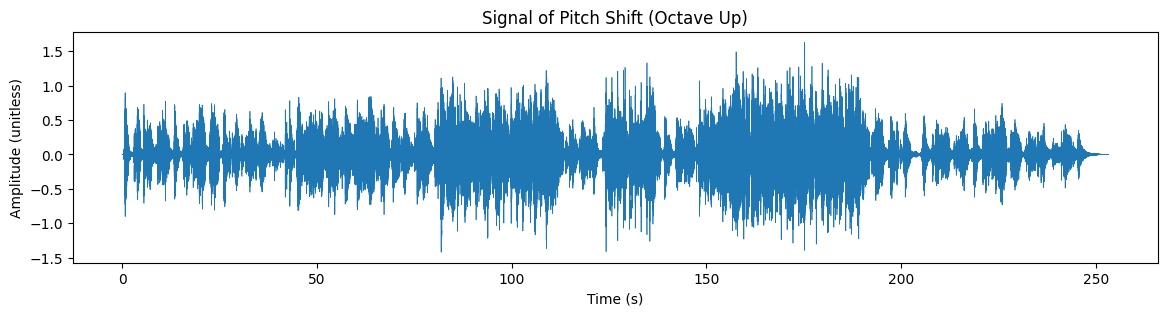

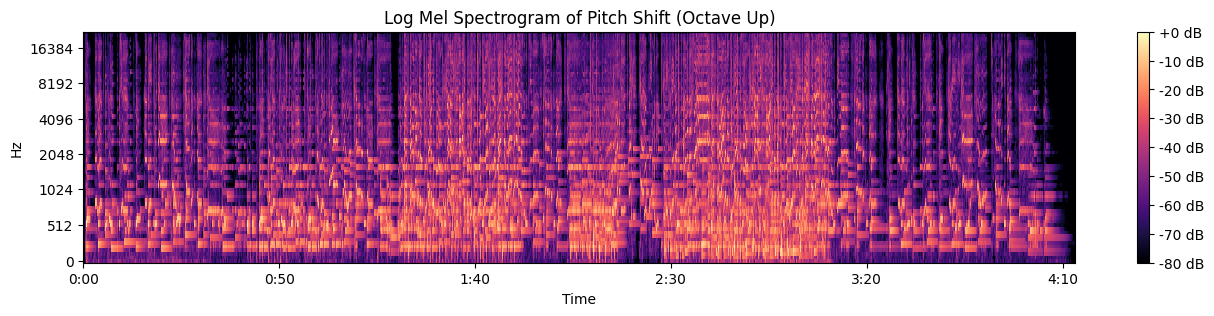

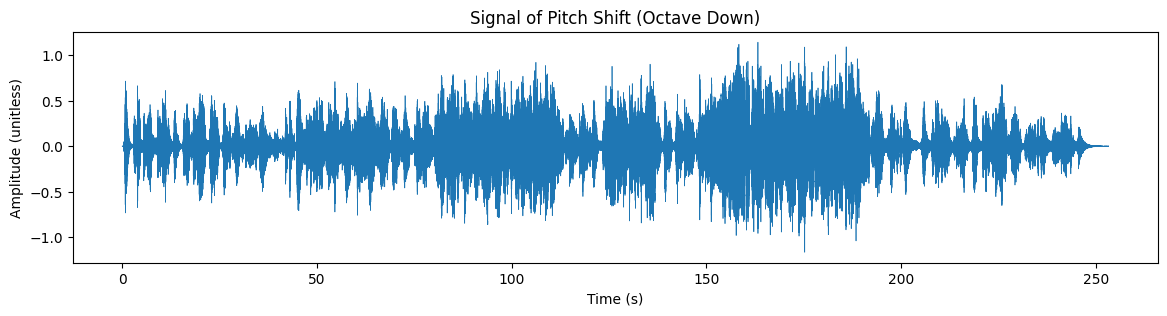

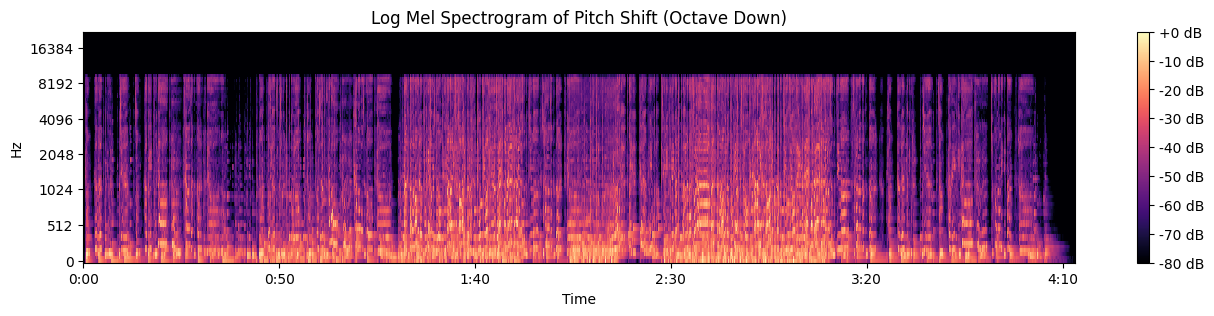

In [ ]:
# Pitch shift 1 octave up
sample, sr = librosa.load(ori_path)
shift_up = pitch_shift(sample, sr, 12)  # bins_per_octave=12 -> n_step = # of semitones
print_graph(shift_up, sr, "Signal of Pitch Shift (Octave Up)")
sgram(shift_up, sr, "Log Mel Spectrogram of Pitch Shift (Octave Up)")

# Pitch shift 1 octave down
shift_down = pitch_shift(sample, sr, -12) # bins_per_octave=12 -> n_step = # of semitones
print_graph(shift_down, sr, "Signal of Pitch Shift (Octave Down)")
sgram(shift_down, sr, "Log Mel Spectrogram of Pitch Shift (Octave Down)")


#Added White Noise Audio Signal and Spectrogram

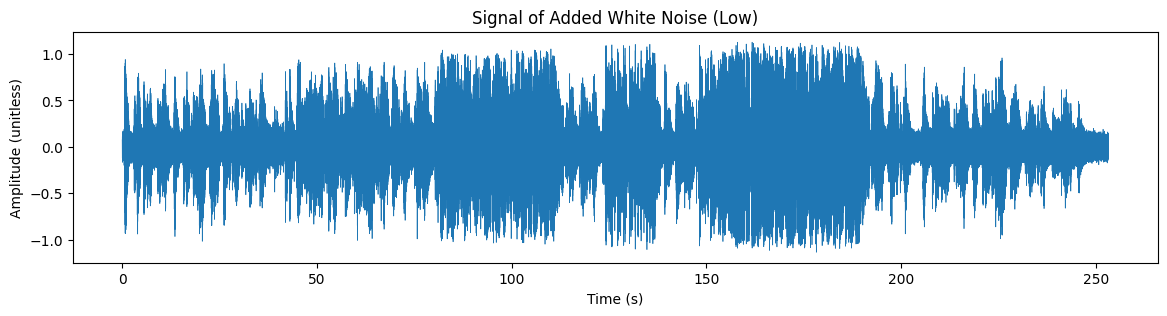

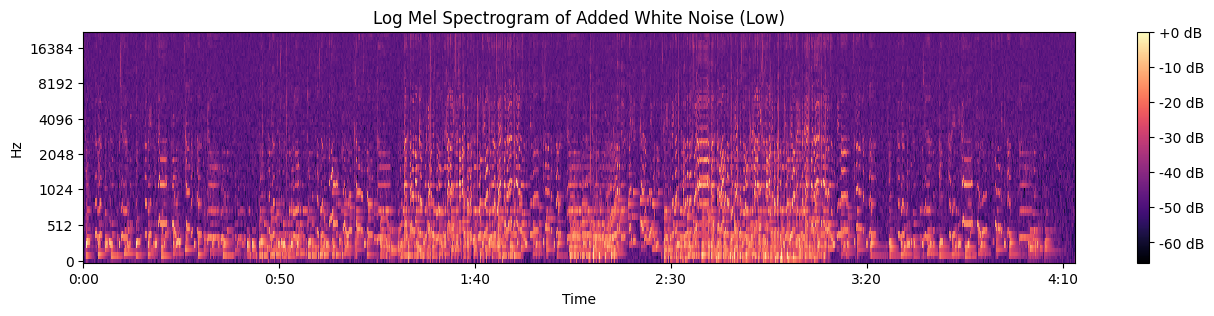

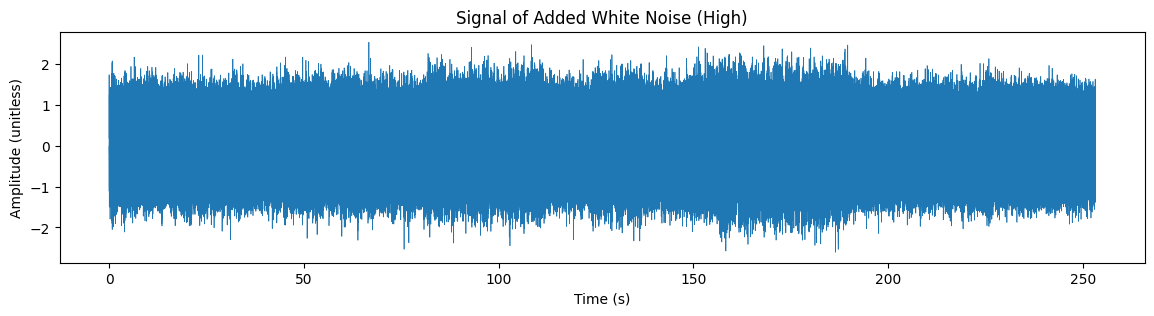

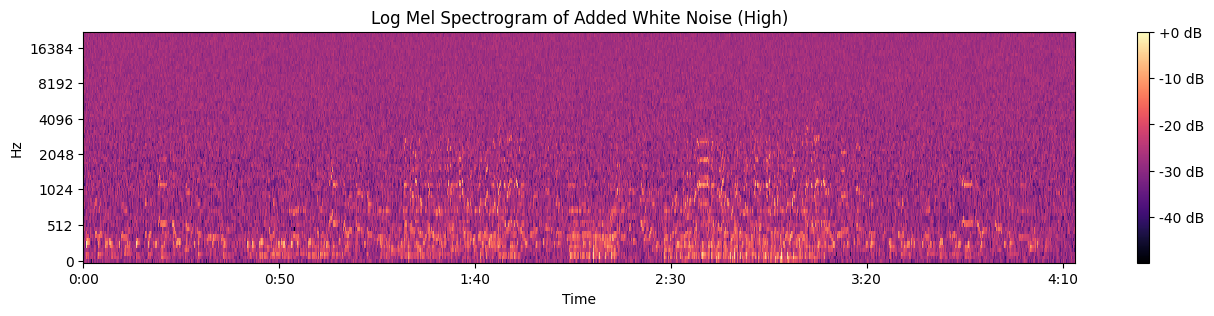

In [ ]:
# White Noise added 
sample, sr = librosa.load(ori_path)

# low intensity = 0.2
low_noise = white_noise(sample, 0.2)
print_graph(low_noise, sr, "Signal of Added White Noise (Low)")
sgram(low_noise, sr, "Log Mel Spectrogram of Added White Noise (Low)")

# high intensity = 2
high_noise = white_noise(sample, 2)
print_graph(high_noise, sr, "Signal of Added White Noise (High)")
sgram(high_noise, sr, "Log Mel Spectrogram of Added White Noise (High)")

#Harmonic Distortion Audio Signal and Spectrogram

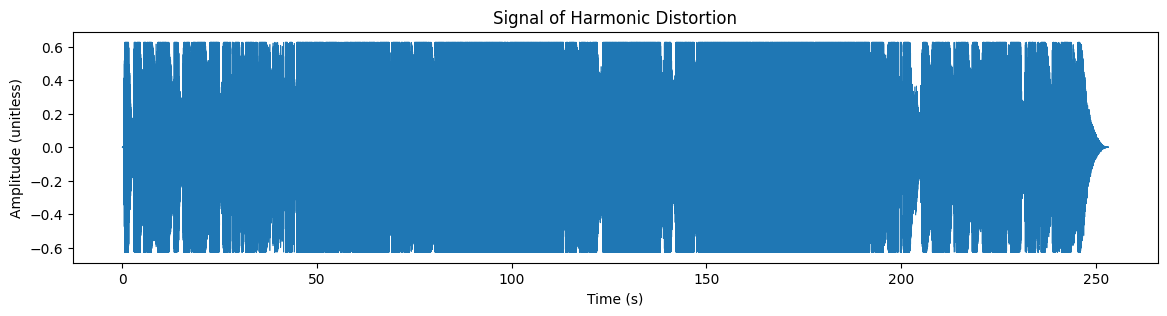

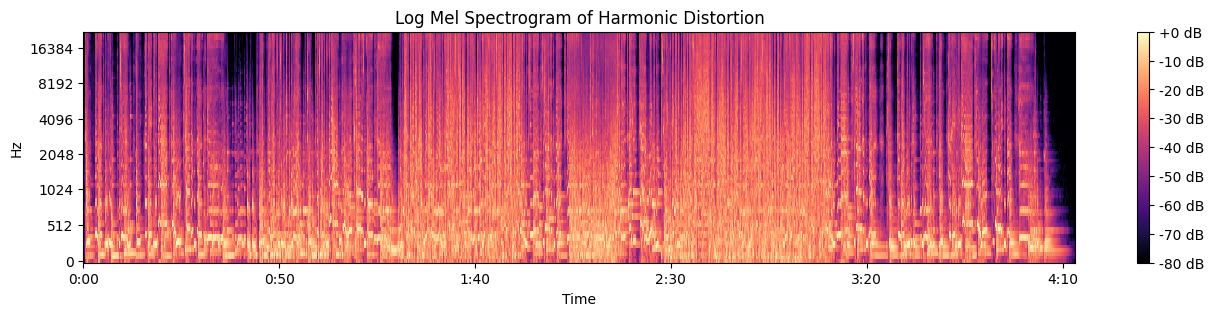

In [ ]:
# Harmonic Distortion applied
sample, sr = librosa.load(ori_path)
distorted = harm_distort(sample)
print_graph(distorted, sr, "Signal of Harmonic Distortion")
sgram(distorted, sr, "Log Mel Spectrogram of Harmonic Distortion")

#Spectrogram Augment Function Definitions

In [ ]:
# spectrogram augments
# frequency mask
def freq_mask(spec, length = 4, zero = True):
  # copy spectrogram data (presever original, return new augmented)
  new_spec = np.copy(spec)
  
  # n_mels = 80 so length can range from 0-80 
  # I think frequency range depends on n_mels but could be wrong 
  # If wrong, then use percentages (see time masking)
  
  # optional : additional line to randomize mask length from 0 - (length-1)
  # mask = random.randrange(0, length)
  
  # get start and end indexes
  start = random.randrange(0, new_spec.shape[0]-length)
  end = start+length

  # if start and end are not valid indexes return spectrogram with no augments
  if start < 0 or start >= new_spec.shape[0]:
    return new_spec
  if end < 0 or end >=new_spec.shape[0]:
    return new_spec

  # replace the mask area with 0 or song mean
  if zero is True: 
    new_spec[:][start:end] = 0
  else :
    new_spec[:][start:end] = new_spec.mean()

  return new_spec


# time masking - Removed
def time_mask(spec, perc = 5, zero = True):
  # basically same proceedure as freq_mask
  new_spec = np.copy(spec)

  # optional : additional line to randomize mask percentage from 0 - (perc-1)
  # mask = random.randrange(0, perc)

  # using percentages because song lengths vary 
  # if lengths are maintained, revert back to using length (see freq_mask)
  length = int((perc/100)*new_spec.shape[1])

  # adjust length if result is 0
  if length == 0:
    length = 1 

  # get start and end indexes
  start = random.randrange(0, new_spec.shape[1]-length)
  end = start+length

  # if start and end are not valid indexes return spectrogram with no augments
  if start < 0 or start >= new_spec.shape[1]:
    return new_spec
  if end < 0 or end >=new_spec.shape[1]:
    return new_spec

  # replace the mask area with 0 or song mean
  if zero is True: 
    new_spec[:][:, start:end] = 0
  else :
    new_spec[:][:, start:end] = new_spec.mean()

  return new_spec

In [ ]:
# # display using imshow
# # color can be included but left out
# # show matplot imshow generated spectrogram of original (no augmentations)
# fig, ax = plt.subplots(figsize=(14, 3))
# ax.set_title("imshow: original")
# img = ax.imshow(log_mel_spectrogram, aspect='auto', origin='lower')
# # fig.colorbar(img, ax=ax)
# plt.show()

# Original Compared to Frequency Mask Spectrograms



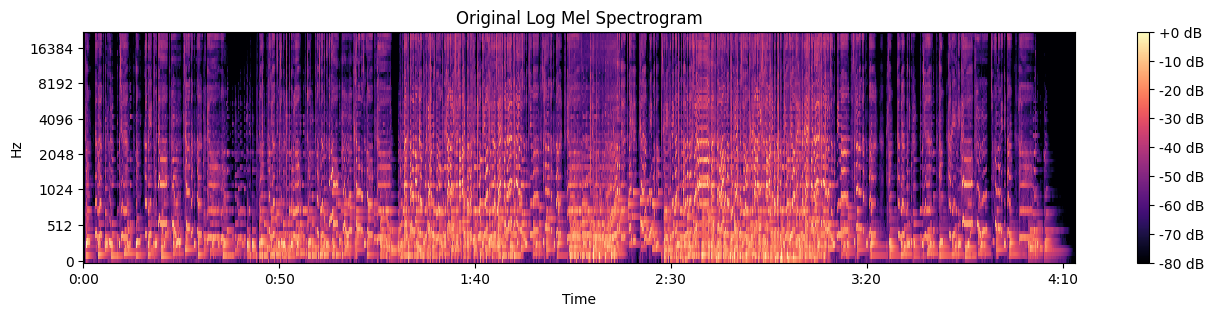

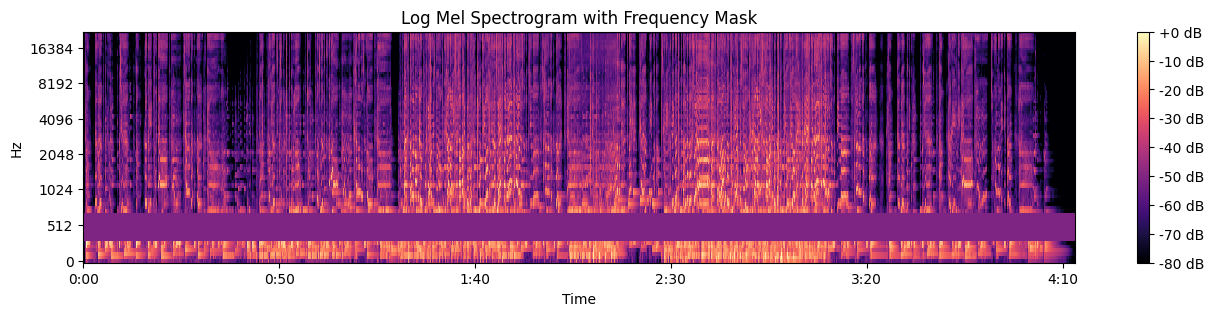

In [ ]:
# load in song
sample, sr = librosa.load(ori_path)

# convert to log mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# apply frequency mask 
# input range length of frequencies to mask [0 - 80)
# inputs : spectrogram data, mask length, replace with 0 T/F
# see freq_mask for more info
spec_f = freq_mask(log_mel_spectrogram, length = 8,  zero = False)

# using librosa to display

# show librosa generated spectrogram of original (no augmentations)
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Original Log Mel Spectrogram")
img1 = librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
fig.colorbar(img1, ax=ax, format='%+2.0f dB')
plt.show()

# show librosa generated spectrogram of frequency mask
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Log Mel Spectrogram with Frequency Mask")
img1 = librosa.display.specshow(spec_f, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
fig.colorbar(img1, ax=ax, format='%+2.0f dB')
plt.show()

# # show matplot imshow generated spectrogram of frequency mask
# fig, ax = plt.subplots(figsize=(14, 3))
# ax.set_title("imshow: frequency mask")
# ax.imshow(spec_f, aspect='auto', origin='lower')
# # fig.colorbar(img, ax=ax)
# plt.show()

# Original Compared to Time Mask Spectrograms (Removed From Training)

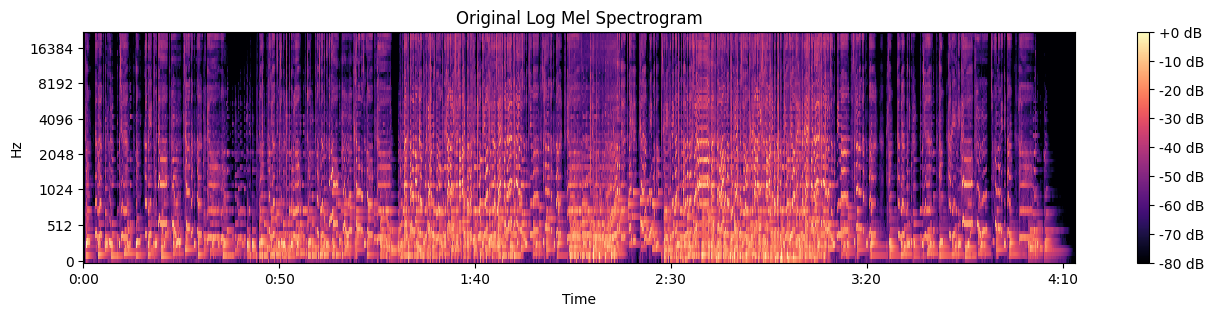

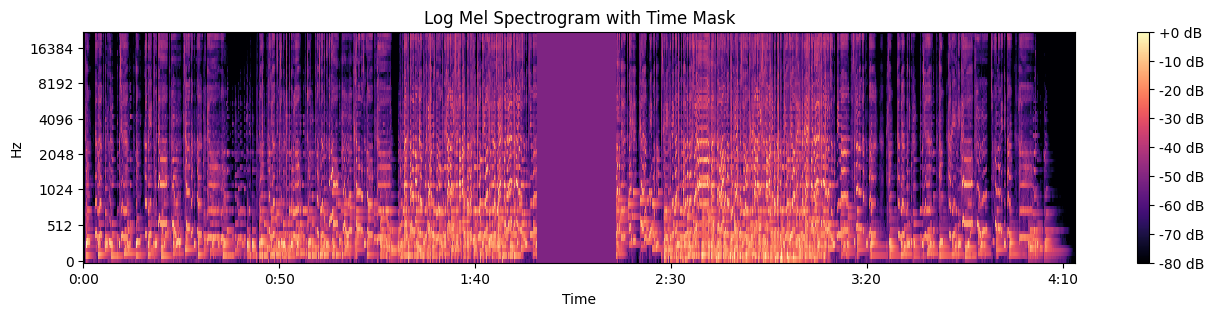

In [ ]:
# load in song
sample, sr = librosa.load(ori_path)

# convert to log mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# apply time mask 
# input range length of time to mask as percentage (0-100) of the total time range
# inputs : spectrogram data, mask percentage, replace with 0 T/F
# see time_mask for more info
spec_t = time_mask(log_mel_spectrogram, perc = 8, zero = False)

# show librosa generated spectrogram of original (no augmentations)
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Original Log Mel Spectrogram")
img1 = librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
fig.colorbar(img1, ax=ax, format='%+2.0f dB')
plt.show()

# show librosa generated spectrogram of time mask
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Log Mel Spectrogram with Time Mask")
img1 = librosa.display.specshow(spec_t, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
fig.colorbar(img1, ax=ax, format='%+2.0f dB')
plt.show()

# # show matplot imshow generated spectrogram of time mask
# fig, ax = plt.subplots(figsize=(16, 3))
# ax.set_title("imshow: time mask")
# ax.imshow(spec_t, aspect='auto', origin='lower')
# # fig.colorbar(img, ax=ax)
# plt.show()

# Show All Plots

In [ ]:
def print_signals(path):
  sample, sr = librosa.load(path)
  print_graph(sample, sr, "Original Signal")

  # 2x speed up
  speed_up = time_stretch(sample, 2)
  print_graph(speed_up, sr, "Signal of Time Stretched (Speed up)")

  # 0.5x slow down
  slow_down = time_stretch(sample, 0.5)
  print_graph(slow_down, sr, "Signal of Time Stretched (Slow Down)")

  # Pitch shift 1 octave up
  shift_up = pitch_shift(sample, sr, 12)  # bins_per_octave=12 -> n_step = # of semitones
  print_graph(shift_up, sr, "Signal of Pitch Shift (Octave Up)")
  
  # Pitch shift 1 octave down
  shift_down = pitch_shift(sample, sr, -12) # bins_per_octave=12 -> n_step = # of semitones
  print_graph(shift_down, sr, "Signal of Pitch Shift (Octave Down)")

  # White Noise added (low intensity = 0.2)
  low_noise = white_noise(sample, 0.2)
  print_graph(low_noise, sr, "Signal of Added White Noise (Low)")

  # White Noise added (low intensity = 0.2)
  high_noise = white_noise(sample, 2)
  print_graph(high_noise, sr, "Signal of Added White Noise (High)")

  # Harmonic Distortion applied
  distorted = harm_distort(sample)
  print_graph(distorted, sr, "Signal of Harmonic Distortion")
  return

def print_sgrams(path):
  sample, sr = librosa.load(path)
  sgram(sample, sr, "Original Log Mel Spectrogram")

  # 2x speed up
  speed_up = time_stretch(sample, 2)
  sgram(speed_up, sr, "Log Mel Spectrogram of Time Stretched (Speed up)")

  # 0.5x slow down
  slow_down = time_stretch(sample, 0.5)
  sgram(slow_down, sr, "Log Mel Spectrogram of Time Stretched (Slow Down)")

  # Pitch shift 1 octave up
  shift_up = pitch_shift(sample, sr, 12)  # bins_per_octave=12 -> n_step = # of semitones
  sgram(shift_up, sr, "Log Mel Spectrogram of Pitch Shift (Octave Up)")

  # Pitch shift 1 octave down
  shift_down = pitch_shift(sample, sr, -12) # bins_per_octave=12 -> n_step = # of semitones
  sgram(shift_down, sr, "Log Mel Spectrogram of Pitch Shift (Octave Down)")

  # White Noise added (low intensity = 0.2)
  low_noise = white_noise(sample, 0.2)
  sgram(low_noise, sr, "Log Mel Spectrogram of Added White Noise (Low)")

  # White Noise added (high intensity = 2)
  high_noise = white_noise(sample, 2)
  sgram(high_noise, sr, "Log Mel Spectrogram of Added White Noise (High)")

  # Harmonic Distortion applied
  distorted = harm_distort(sample)
  sgram(distorted, sr, "Log Mel Spectrogram of Harmonic Distortion")
  return

### Show All Signal Plots

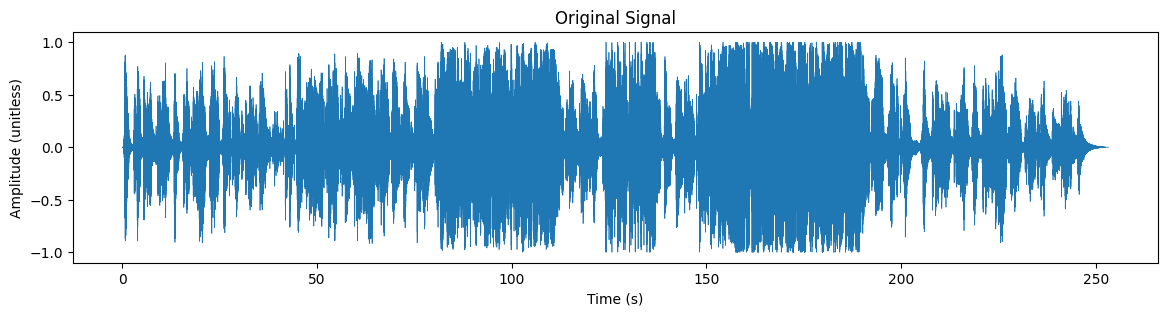

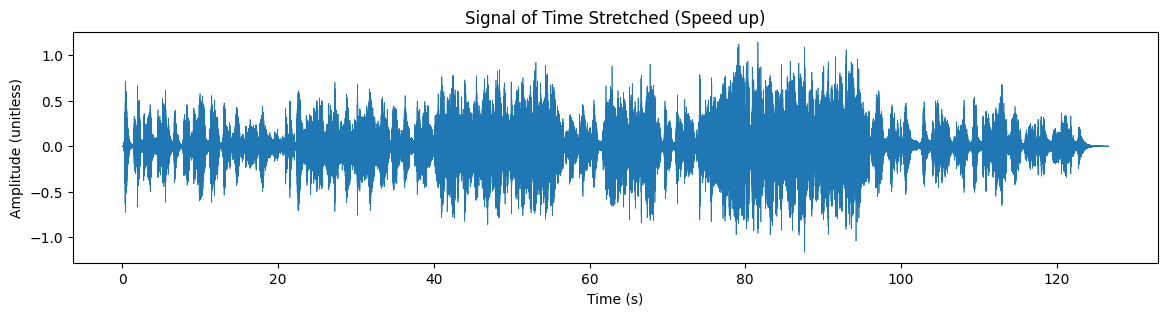

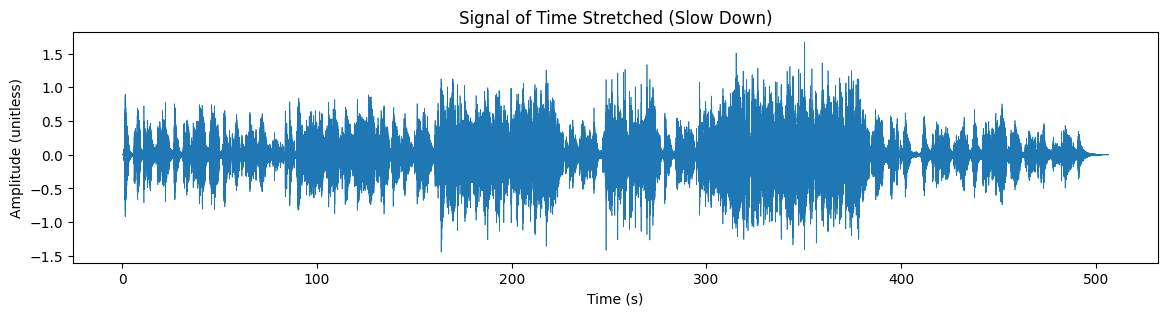

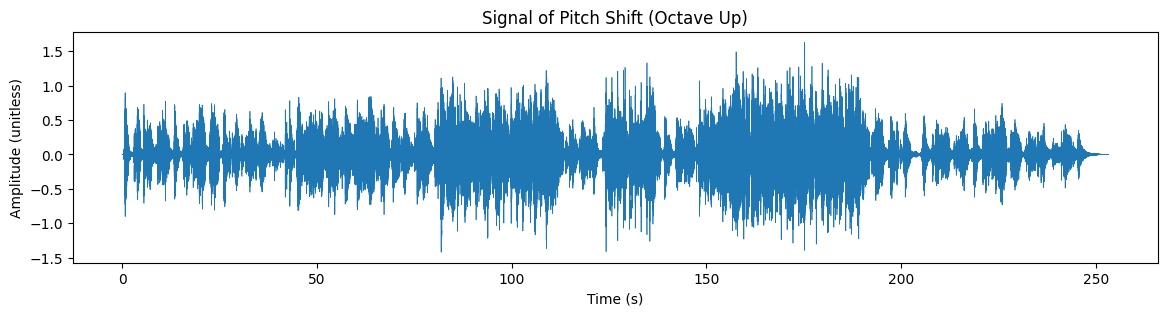

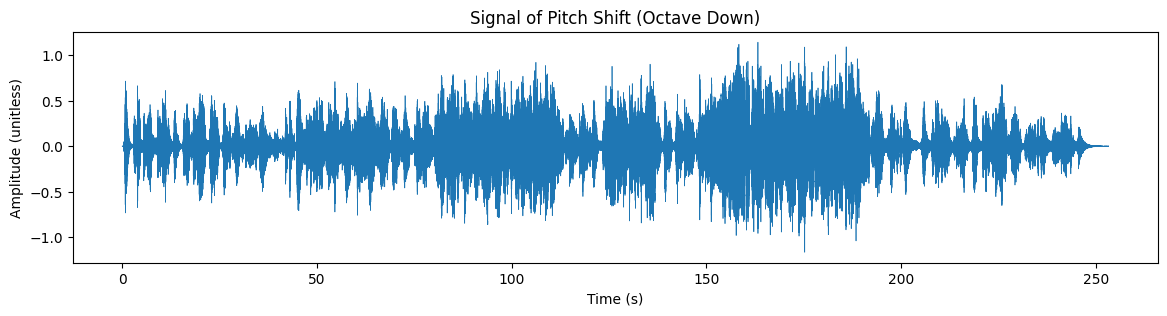

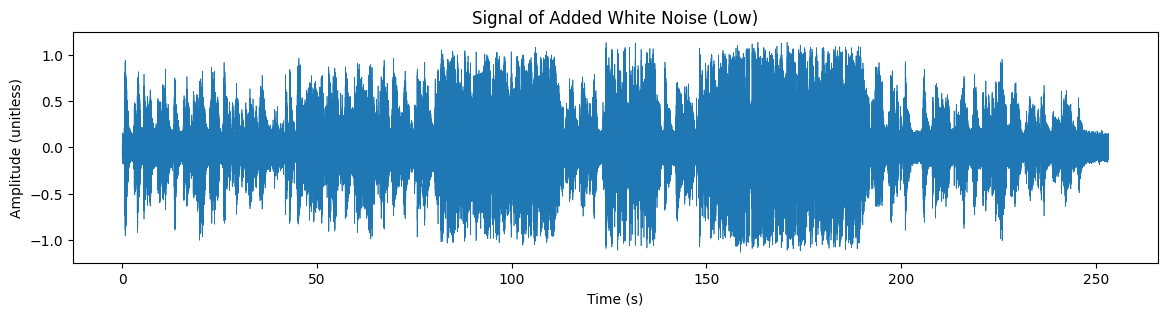

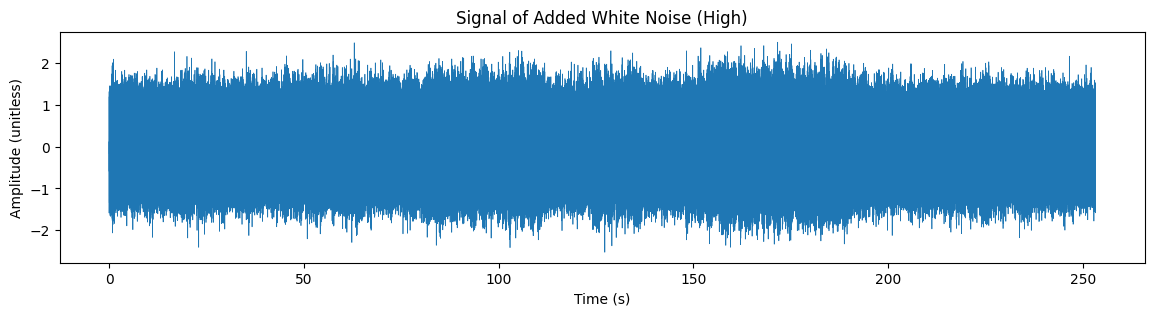

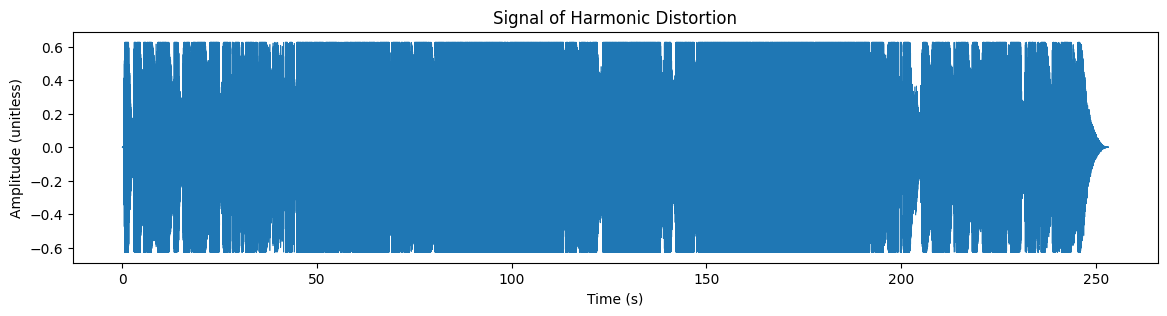

In [ ]:
print_signals(ori_path)

# Show All Spectrograms

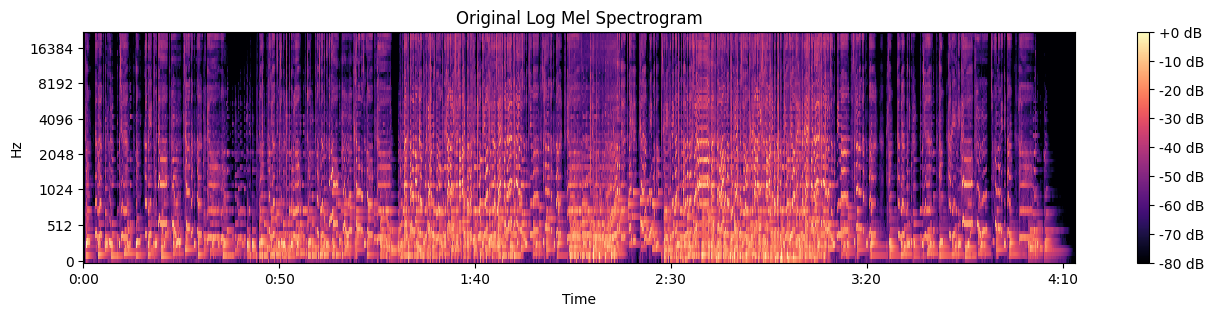

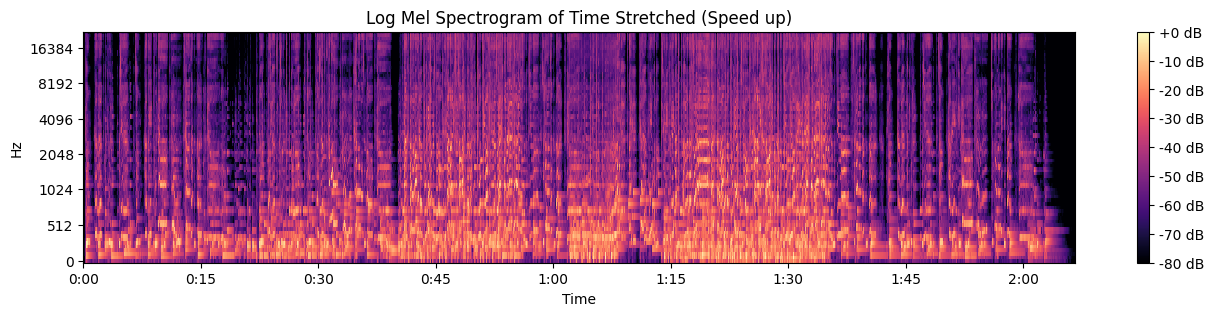

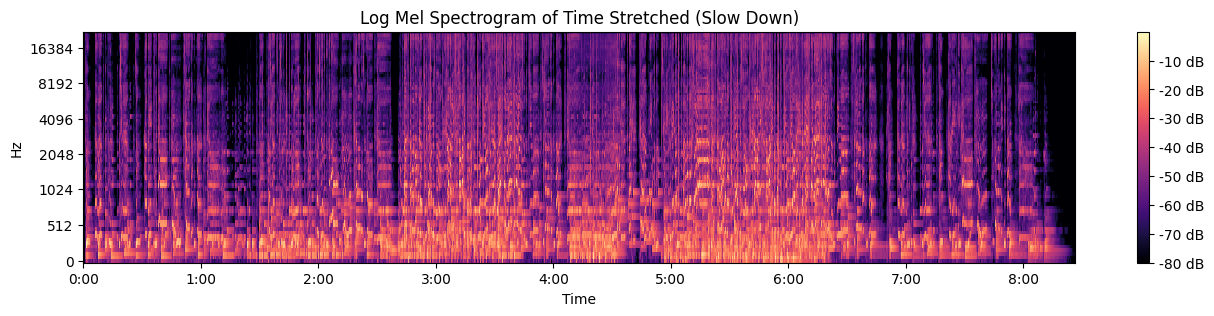

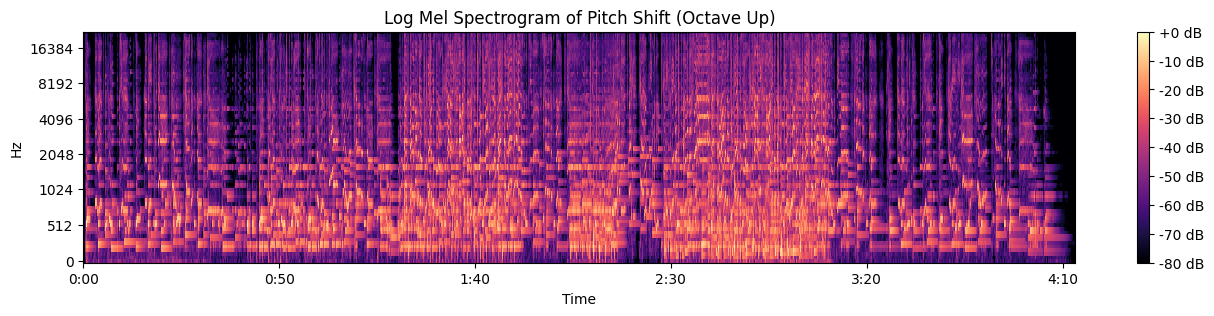

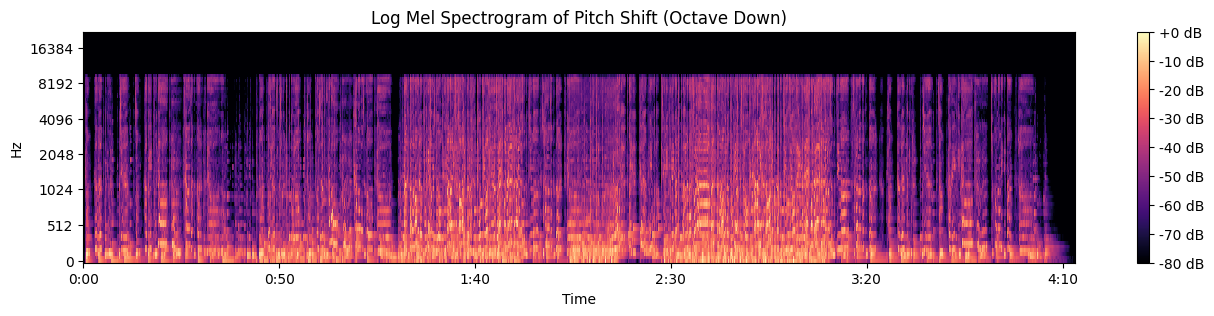

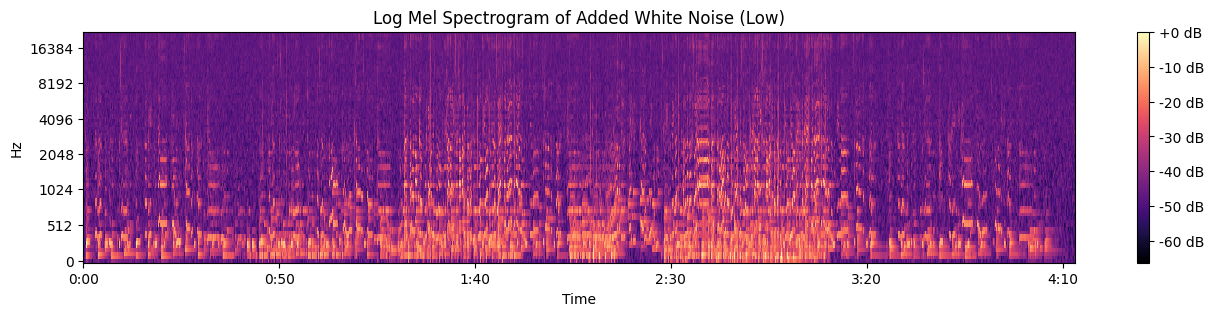

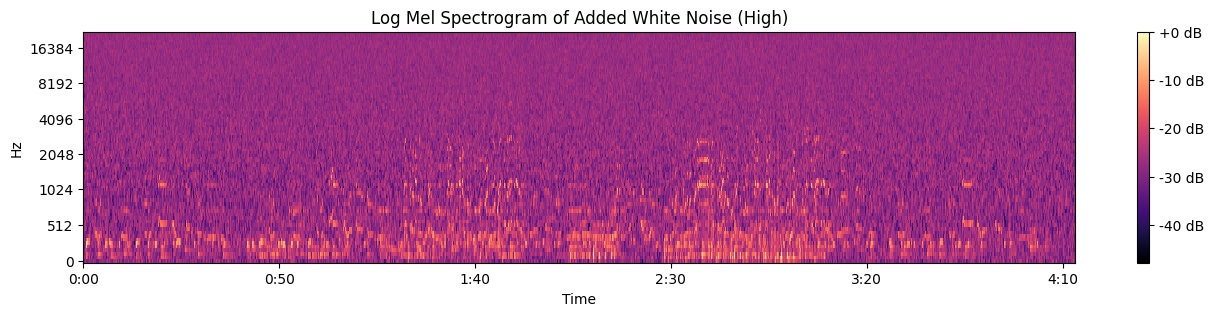

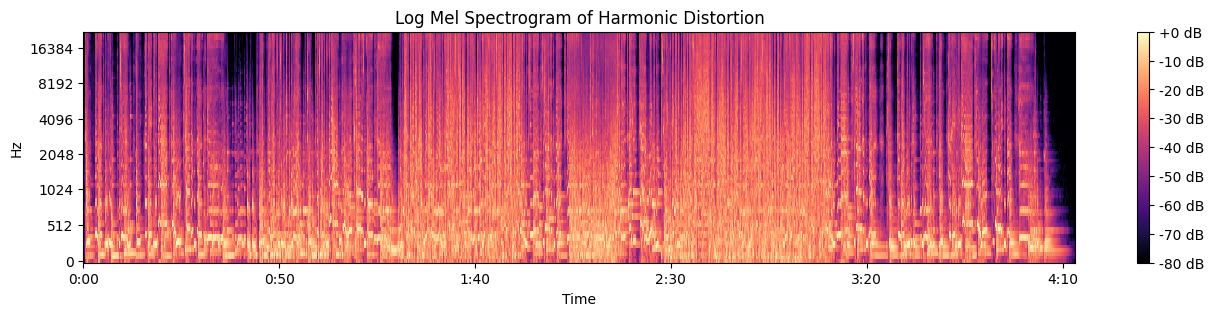

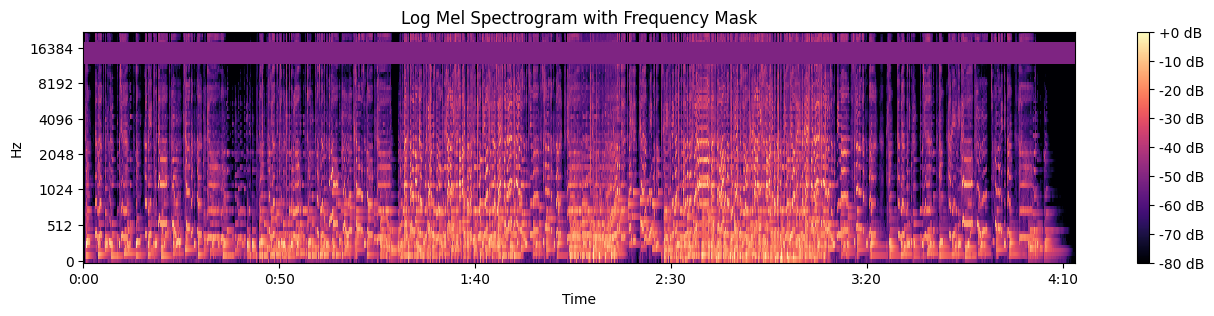

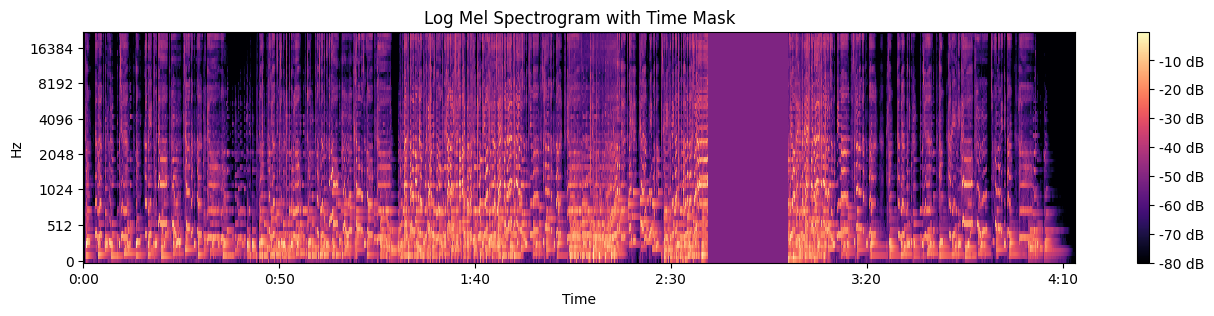

In [ ]:
print_sgrams(ori_path)
# load in song
sample, sr = librosa.load(ori_path)

# convert to log mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=sample, sr=sr, n_fft=1024, hop_length=256, n_mels=80)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# apply frequency mask 
# input range length of frequencies to mask [0 - 80)
# inputs : spectrogram data, mask length, replace with 0 T/F
# see freq_mask for more info
spec_f = freq_mask(log_mel_spectrogram, length = 8,  zero = False)

# apply time mask 
# input range length of time to mask as percentage (0-100) of the total time range
# inputs : spectrogram data, mask percentage, replace with 0 T/F
# see time_mask for more info
spec_t = time_mask(log_mel_spectrogram, perc = 8, zero = False)

# using librosa to display

# # show librosa generated spectrogram of original (no augmentations)
# fig, ax = plt.subplots(figsize=(16, 3))
# ax.set_title("Original Log Mel Spectrogram")
# img1 = librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
# fig.colorbar(img1, ax=ax, format='%+2.0f dB')
# plt.show()

# show librosa generated spectrogram of frequency mask
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Log Mel Spectrogram with Frequency Mask")
img1 = librosa.display.specshow(spec_f, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
fig.colorbar(img1, ax=ax, format='%+2.0f dB')
plt.show()

# # show matplot imshow generated spectrogram of frequency mask
# fig, ax = plt.subplots(figsize=(14, 3))
# ax.set_title("imshow: frequency mask")
# ax.imshow(spec_f, aspect='auto', origin='lower')
# # fig.colorbar(img, ax=ax)
# plt.show()

# show librosa generated spectrogram of time mask
fig, ax = plt.subplots(figsize=(16, 3))
ax.set_title("Log Mel Spectrogram with Time Mask")
img1 = librosa.display.specshow(spec_t, x_axis='time', y_axis='mel', sr=sr*2, ax=ax)
fig.colorbar(img1, ax=ax, format='%+2.0f dB')
plt.show()

# # show matplot imshow generated spectrogram of time mask
# fig, ax = plt.subplots(figsize=(16, 3))
# ax.set_title("imshow: time mask")
# ax.imshow(spec_t, aspect='auto', origin='lower')
# # fig.colorbar(img, ax=ax)
# plt.show()

In [ ]:
# Download all augments as separate files

# print("[2011] Alicia [OST Alicia].wav")
# sample, sr = librosa.load("[2011] Alicia [OST Alicia].wav")
# print("original ", sample.shape, sr)
# ts = time_stretch(sample, 3)
# print("time stretch ", ts.shape)
# hd = harm_distort(sample)
# print("harmonic distortion ", hd.shape)
# wn = white_noise(sample, 2)
# print("white noise ", wn.shape)
# ps = pitch_shift(sample, sr, 2)
# print("pitch shift ", ps.shape)

# sf.write("ts.wav", ts, sr)
# sf.write("hd.wav", hd, sr)
# sf.write("wn.wav", wn, sr)
# sf.write("ps.wav", ps, sr)

# audio, sr = librosa.load("[2011] Alicia [OST Alicia].wav", sr=16000)
# print("original", librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("ts.wav", sr=16000)
# print("ts",librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("hd.wav", sr=16000)
# print("hd", librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("wn.wav", sr=16000)
# print("wn", librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("ps.wav", sr=16000)
# print("ps", librosa.feature.mfcc(y=audio, sr=sr).shape)

# print("\n[2011] Someday [OST Dream High].wav")
# sample, sr = librosa.load("[2011] Someday [OST Dream High].wav")
# print("original ", sample.shape, sr)
# ts2 = time_stretch(sample, 3)
# print("time stretch ", ts2.shape)
# hd2 = harm_distort(sample)
# print("harmonic distortion ", hd2.shape)
# wn2 = white_noise(sample, 2)
# print("white noise ", wn2.shape)
# ps2 = pitch_shift(sample, sr, 2)
# print("pitch shift ", ps2.shape)

# sf.write("ts2.wav", ts2, sr)
# sf.write("hd2.wav", hd2, sr)
# sf.write("wn2.wav", wn2, sr)
# sf.write("ps2.wav", ps2, sr)

# audio, sr = librosa.load("[2011] Someday [OST Dream High].wav", sr=16000)
# print("original", librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("ts2.wav", sr=16000)
# print("ts2",librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("hd2.wav", sr=16000)
# print("hd2", librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("wn2.wav", sr=16000)
# print("wn2", librosa.feature.mfcc(y=audio, sr=sr).shape)
# audio, sr = librosa.load("ps2.wav", sr=16000)
# print("ps2", librosa.feature.mfcc(y=audio, sr=sr).shape)